In [4]:
import numpy as np
import scipy
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os

In [5]:
base_dir = '/home2/ebrahim/neural_seq_decoder/'

The goal is to create a pandas dataframe with the following column header:

C1: neural data (power)
C2: neural data (threshold crossings)
C3: delay (0) or go (1)
C4: block number 
C5: session number 
C6: chang sentence id

In [11]:
def map_from_channel_index_to_brain_area(index):
    if 0 <= index <= 31:
        return 'ia_6v'
    elif 32 <= index <= 63:
        return 'sa_6v'
    elif 64 <= index <= 95:
        return 'sp_6v'
    elif 96 <= index <= 127:
        return 'ia_6v'
    elif 128 <= index <= 159:
        return 'ia_44'
    elif 160 <= index <= 191:
        return 'sp_44'
    elif 192 <= index <= 223:
        return 'sa_44'
    elif 224 <= index <= 255:
        return 'ip_44'
    else:
        raise ValueError("Index out of range. Valid indices are between 0 and 255.")

def bin_relative_to_go_cue(trialNumber, trialState):
    
    '''
    :param list trialNumber:  
    :param list trialState: 
    
    trialNumber and trialState should contain the trial numbers and trial state for lists within a block.
    This function will return the bin relative to go cue for each trial.
    '''
            
    assert trialNumber.shape[0] == trialState.shape[0], print("Shapes are mismatched")
    trialNum_unq, trialNum_count = np.unique(trialNumber, return_counts=True)
    
    bil_rel_to_go = []
    
    for tn in trialNum_unq:
        
        # get indices for given trial
        tn_idxs = np.argwhere(trialNumber==tn).squeeze()

        # store number of time bins for that trial
        num_bins_trial = tn_idxs.shape[0]
        
        # get trialState for selected trial
        trialState_tn = trialState[tn_idxs].squeeze()
        
        # find index where go cue occurs
        first_go_idx = np.argwhere(trialState_tn==1).squeeze()[0]

        # add list that increases by 1 each element, and element at first_go_idx is 0
        bil_rel_to_go.extend(np.arange(num_bins_trial) - first_go_idx)
        
    return bil_rel_to_go

def get_trial_numbers(session_X):
    
    '''
    :param dict session_X:
    
    Assign each bin a trial number. 
    '''
    
    trialState = session_X['trialState']
    trialNumber = 0
    trialNumber_store = []
    
    for i,t in enumerate(trialState):
        
        trialNumber_store.append(trialNumber)
        
        # last trial
        if i == len(trialState)-1:
            trialNumber += 1
            
        # if the next timestep is a delay, then a new trial has started.
        # I do greater than 0 (instead of equal to 1) because sometimes 
        # trialState is equal to 3 (for reasons unknown...)
        elif t > 0 and trialState[i+1] == 0:
            trialNumber+=1
            
    return np.array(trialNumber_store)
            
def select_block_ids(session_dict, select_block):
    
    '''
    :param dict session_dict: session data loaded using scipy  
    :param str select_block: selected block, can be Switchboard or Chang

    Returns block numbers corresponding to the selected block.
    '''
    
    blockType = session_dict['blockTypes'].squeeze()
    blockList = session_dict['blockList'].squeeze()
    
    selected_block_numbers = []
    
    for bt, bl in zip(blockType, blockList):
        
        if select_block in bt[0]:
            selected_block_numbers.append(bl)
            
    return selected_block_numbers

def sentences_num_trials(trialNumber, sentences):
    
    '''
    :param list trialNumber: trial number (integer) for selected trials for each 20 ms bin
    :param list sentences: list of length number of total trials, indicating sentence shown
    on that trial.
    
    Currently, a single sentence is only provided for each trial. This function 
    returns a list of of length trialNumber, which contains the sentence for each bin. 
    '''
    
    # obtain unqiue trial numbers and counts
    # the counts indicate the number of 20ms bins that belong to that trial
    trialNumber_unique, trialNumber_counts = np.unique(trialNumber, return_counts=True)
    
    # select sentences corresponding to trials
    sentences_selected = sentences[trialNumber_unique] 
    
    # map sentences to ids 
    sentence_repeated = []
    
    for i, s in enumerate(sentences_selected):
        sentence_num_bins = trialNumber_counts[i] # number of time bins for that trial
        s_repeated = np.repeat(s, sentence_num_bins) # repeat sentence num bins times
        sentence_repeated.extend(s_repeated) # add it to list 

    return np.array(sentence_repeated)


def zscore_data(neural_data):
    
    '''
    :param ndarray neural_data: num_time_bins x channels, 
    
    Z score each channel
    '''
    
    channel_means = np.mean(neural_data, axis=0) # take mean across time
    channel_stds = np.std(neural_data, axis=0) # take std across time 
    
    # Avoid division by zero by setting a minimum threshold for standard deviation
    min_std_threshold = 1e-6
    channel_stds = np.where(channel_stds < min_std_threshold, 1, channel_stds)
    
    return (neural_data - channel_means)/channel_stds


def print_lengths_before_adding(ba, i, num_time_bins, spikePow_sb, threshCross_sb, trialState_sb, 
                                sb_repeated, session_name_repeated, trialNumber_sb, sentence_sb, bin_relative_to_go_cue_list):
    # Calculate lengths
    brain_region_length = len(np.repeat(ba, num_time_bins))
    elec_num_length = len(np.repeat(i, num_time_bins))
    pow_length = len(spikePow_sb[:, i])
    tx_length = len(threshCross_sb[:, i])
    trialState_length = len(trialState_sb)
    blockNum_length = len(sb_repeated)
    session_length = len(session_name_repeated)
    trialNumber_length = len(trialNumber_sb)
    sentences_length = len(sentence_sb)
    bin_rel_go_length = len(bin_relative_to_go_cue_list)
    
    # Print lengths
    print(f"Length of 'brain_region': {brain_region_length}")
    print(f"Length of 'elec_num': {elec_num_length}")
    print(f"Length of 'pow-{ba}_{i}': {pow_length}")
    print(f"Length of 'tx-{ba}_{i}': {tx_length}")
    print(f"Length of 'trialState': {trialState_length}")
    print(f"Length of 'blockNum': {blockNum_length}")
    print(f"Length of 'session': {session_length}")
    print(f"Length of 'trialNumber': {trialNumber_length}")
    print(f"Length of 'sentences': {sentences_length}")
    print(f"Length of 'bin_rel_go': {bin_rel_go_length}")

def store_data_to_pandas(session_dict, selected_block_numbers, session_name):
    
    '''
    :param dict session_dict: session data loaded using scipy 
    :param list selected_block_numbers: which block numbers to store into dataframe
    :param str session_name: name of session data 
    
    Returns a pandas df with the following column
        blockNum: the block number (integer)
        session: session name (str)
        spikePow: the power in 20 ms bins after high pass filtering 250 Hz for each of the 256 channels
        threshCross:  number of binned threshold crossings (4.5 x RMS threshold) for each of the 256 channels
        trialState: 0 for delay period, 1 for go period
        sentence: sentence corresponding to each time bin (str)
        trialNumber: trial number corresponding to each bin (int)
    '''
    
    trialNumbers = get_trial_numbers(session_dict)
    blockNum = session_dict['blockNum'].squeeze()
    spikePow = session_dict['spikePow'].squeeze()
    threshCross = session_dict['tx2'].squeeze()
    trialState = session_dict['trialState'].squeeze()
    sentences = session_dict['sentences'].squeeze()
    
    store_data_in_dict = {'blockNum': [], 'session': [], 'trialState': [], 
    'sentences': [], 'trialNumber': [], 'bin_rel_go': []}

    
    num_channels = spikePow.shape[1]
    
    for i in range(num_channels):
        ba = map_from_channel_index_to_brain_area(i)
        store_data_in_dict[f'pow-{ba}-{i}'] = []
        store_data_in_dict[f'tx-{ba}-{i}'] = []
        
    for sb in selected_block_numbers:
        
        print(f"{session_name}, {sb}")
        
        # get idxs corresponding to the specified block (sb)
        sb_idxs = np.argwhere(blockNum==sb).squeeze()
        
        num_time_bins = sb_idxs.shape[0]
        
        # select neural data (both spikePow and threshold crossings)
        spikePow_sb = zscore_data(spikePow[sb_idxs].squeeze())
        threshCross_sb = zscore_data(threshCross[sb_idxs].squeeze())
        
        # trialState is 0 (delay) or 1 (go cue)
        trialState_sb = trialState[sb_idxs].squeeze()
        
        # repeat block number and session name to store in long format 
        sb_repeated = np.repeat(sb, num_time_bins)
        session_name_repeated = np.repeat(session_name, num_time_bins)
        
        # neural data is stored in 20ms bins. trialNumbers indicates that trial
        # that each bin belongs to
        trialNumber_sb = trialNumbers[sb_idxs].squeeze()
        
        # for each trial, store bin idx relative to go cue
        bin_relative_to_go_cue_list = bin_relative_to_go_cue(trialNumber_sb, trialState_sb)
        
        sentence_sb = sentences_num_trials(trialNumber_sb, sentences)
        
        for i in range(num_channels):
            
            ba = map_from_channel_index_to_brain_area(i)
            
            # store high pass power and threshold crossings
            store_data_in_dict[f'pow-{ba}-{i}'].extend(spikePow_sb[:, i])
            store_data_in_dict[f'tx-{ba}-{i}'].extend(threshCross_sb[:, i])
            
            
        store_data_in_dict['trialState'].extend(trialState_sb)
        store_data_in_dict['blockNum'].extend(sb_repeated)
        store_data_in_dict['session'].extend(session_name_repeated)
        store_data_in_dict['trialNumber'].extend(trialNumber_sb)
        store_data_in_dict['sentences'].extend(sentence_sb)
        store_data_in_dict['bin_rel_go'].extend(bin_relative_to_go_cue_list)
        
        #print_lengths(store_data_in_dict)
        
    return pd.DataFrame(store_data_in_dict)


def dataframe_size_in_gb(df):
    # Get the memory usage of the DataFrame in bytes
    memory_usage_bytes = df.memory_usage(deep=True).sum()
    # Convert bytes to gigabytes
    memory_usage_gb = memory_usage_bytes / (1024 ** 3)
    return memory_usage_gb


In [16]:
load_data_from_pickle = True
resave_data = False

In [14]:
if load_data_from_pickle:
    
    all_sessions_chang = pd.read_pickle(f"{base_dir}/processed_data/all_sessions_chang_pd.pkl")
    
else:
    
    session_pd_store = []
    counter = 0
    sessions_without_chang = ['04.28', '05.05', '07.29']
    for file in os.listdir(f"{base_dir}sentences/"):

        if np.sum([1 for x in sessions_without_chang if x in file]) > 0:
            print("skipping ", file)
            continue
        
        print("loading session data")
        session_dict = scipy.io.loadmat(f'{base_dir}sentences/{file}')
        session_name = file.split('_')[0].replace('t12.2022.', '')
        
        chang_block_nums = select_block_ids(session_dict, 'Chang')
        
        if len(chang_block_nums) == 0:
            print(f"session {session_name} does not have chang sentences")
            sessions_without_chang.append(file)
            continue
        
        session_chang_pd = store_data_to_pandas(session_dict, chang_block_nums, session_name)
        session_pd_store.append(session_chang_pd)
        
    all_sessions_chang = pd.concat(session_pd_store)
    
if resave_data:
    all_sessions_chang.to_pickle('/home2/ebrahim/neural_seq_decoder/processed_data/all_sessions_chang_pd.pkl')

In [17]:
all_sessions_chang.head()

,blockNum,session,trialState,sentences,trialNumber,bin_rel_go,pow-ip_6v-0,tx-ip_6v-0,pow-ip_6v-1,tx-ip_6v-1,...,pow-ip_44-251,tx-ip_44-251,pow-ip_44-252,tx-ip_44-252,pow-ip_44-253,tx-ip_44-253,pow-ip_44-254,tx-ip_44-254,pow-ip_44-255,tx-ip_44-255
0,18,08.23,0,My family is here,560,-185,-0.771812,-0.579488,-0.545274,-0.1277,...,-0.746408,-0.342797,-0.351113,-0.328963,-0.199329,1.800816,-0.129325,-0.521967,1.112226,1.517718
1,18,08.23,0,My family is here,560,-184,-1.004254,-0.579488,-0.272285,-0.1277,...,0.309446,-0.342797,-0.117031,-0.328963,-0.858849,-0.418453,-0.526677,-0.521967,-0.042407,-0.313161
2,18,08.23,0,My family is here,560,-183,-1.333889,-0.579488,-0.375999,-0.1277,...,-0.669067,-0.342797,-0.025975,-0.328963,-0.574143,-0.418453,-0.662006,-0.521967,0.817203,0.297132
3,18,08.23,0,My family is here,560,-182,-0.238668,1.309894,-1.099739,-0.1277,...,-0.610652,-0.342797,-0.765144,-0.328963,-0.616568,-0.418453,2.035415,1.100507,2.203868,-0.313161
4,18,08.23,0,My family is here,560,-181,-0.835946,-0.579488,-0.840233,-0.1277,...,-0.269211,-0.342797,-0.382907,-0.328963,-0.429959,-0.418453,-0.641144,1.100507,0.478694,2.128010


In [18]:
all_sessions_chang_delay_go = all_sessions_chang.loc[all_sessions_chang.trialState!=3]
all_sessions_chang_delay_go.trialState.unique()
dataframe_size_in_gb(all_sessions_chang)

1.6122887311503291

In [19]:
# Create a function to determine the sort order
def sort_key(col_name):
    # Define the order of column groups
    order = [
        'ip_6v', 'ia_6v', 'sp_6v', 'sa_6v',
        'ip_44', 'ia_44', 'sp_44', 'sa_44'
    ]

    for idx, group in enumerate(order):
        if group in col_name:
            return (idx, col_name)
    return (len(order), col_name)  # If not in any group, place it at the end



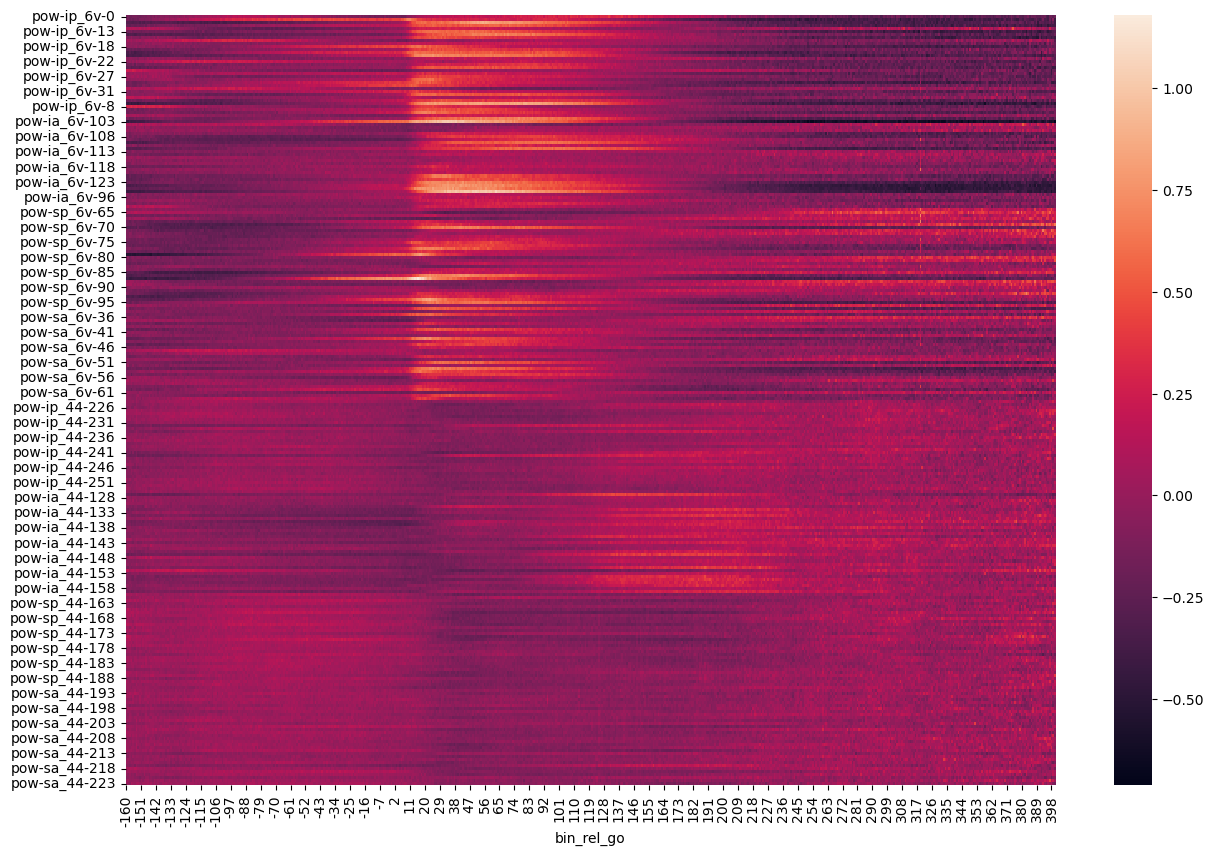

In [20]:
num_channels = 256
start_time = -160
end_time = 400
# Assuming filtered_df is your DataFrame
sp_columns = [col for col in all_sessions_chang_delay_go.columns if col.startswith('pow-')] # spikepow columns

filtered_df = all_sessions_chang_delay_go[(all_sessions_chang_delay_go['bin_rel_go'] >= start_time) & (all_sessions_chang_delay_go['bin_rel_go'] <= end_time)]

# Group by 'bin_rel_go' and calculate the mean of the specified columns
mean_across_trials = filtered_df.groupby(['bin_rel_go'])[sp_columns].mean().reset_index()

# Reorder columns based on the custom sort key
mean_across_trials = mean_across_trials[sorted(mean_across_trials.columns, key=sort_key)]

# Set 'bin_rel_go' as the index
mean_across_trials.set_index('bin_rel_go', inplace=True)

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(mean_across_trials.T, cbar=True)

plt.savefig(f"/home2/ebrahim/neural_seq_decoder/figures/chang/sent_avg", dpi=300)
plt.show()
plt.close()

In [21]:
# Function to count words in a sentence
def count_words(sentence):
    return len(sentence.split())

# Create a new column with the length of each sentence in number of words
all_sessions_chang_delay_go.loc[:, 'sentence_length'] = all_sessions_chang_delay_go['sentences'].apply(count_words)


/tmp/ipykernel_1214314/1865583962.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_sessions_chang_delay_go.loc[:, 'sentence_length'] = all_sessions_chang_delay_go['sentences'].apply(count_words)
/tmp/ipykernel_1214314/1865583962.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_sessions_chang_delay_go.loc[:, 'sentence_length'] = all_sessions_chang_delay_go['sentences'].apply(count_words)


In [ ]:
def extract_br(channel_name):
    
    return channel_name.split('-')[1]

In [22]:
start_time = -150
end_time = 0
power_in_areas = {'power':[], 'brain_region': [], 'sentence_length': []}
# Assuming filtered_df is your DataFrame
sp_columns = [col for col in all_sessions_chang_delay_go.columns if col.startswith('pow-')] # spikepow columns
for sent in np.unique(all_sessions_chang_delay_go.sentences):

    
    single_sentence_pd = all_sessions_chang_delay_go.loc[all_sessions_chang_delay_go.sentences==sent]
    filtered_df = single_sentence_pd[(single_sentence_pd['bin_rel_go'] >= start_time) & (single_sentence_pd['bin_rel_go'] <= end_time)]
  
    # Group by 'bin_rel_go' and calculate the mean of the specified columns
    mean_across_trials = filtered_df[sp_columns].mean().reset_index()
    
    mean_across_trials.columns = ['channel_name', 'pow']
    
        # Apply the function and create a new column 'brain_region'
    mean_across_trials['brain_region'] = mean_across_trials['channel_name'].apply(extract_br)

    mean_across_trials.groupby('brain_region')['pow'].mean()
    
    for row in mean_across_trials.groupby('brain_region')['pow'].mean().reset_index().iterrows():
        power_in_areas['power'].append(float(row[1].iloc[1]))
        power_in_areas['brain_region'].append(row[1].iloc[0])
        power_in_areas['sentence_length'].append(single_sentence_pd.sentence_length.iloc[0])
        
power_in_areas = pd.DataFrame(power_in_areas)

NameError: name 'extract_br' is not defined

In [70]:
all_sessions_chang_delay_go.sentences.unique()

array(['My family is here', 'My family is very comfortable', 'I need you',
       'You are not right', 'Hello how are you?', 'My family is outside',
       'Yes', 'Do you feel comfortable?', 'I am not okay',
       'Here is my computer', 'How do you feel?', 'Please tell my family',
       'Please clean it', 'It is good', 'Where is it?', 'I am outside',
       'They have faith', 'Please bring my glasses here', 'Faith is good',
       'My computer is clean', 'I hope it is clean', 'That is very clean',
       'Are you tired?', 'No', 'It is comfortable',
       'I do not feel comfortable', 'I like my nurse',
       'My glasses are clean', 'I am not hungry',
       'They are coming outside', 'I am okay', 'Are you going outside?',
       'They are coming here', 'I am going outside',
       'I feel very comfortable', 'How do you like my music?',
       'They are going outside', 'I feel very hungry', 'I am not going',
       'What do you do?', 'I am thirsty', 'Bring my glasses please',
       

brain_region
ia_44   -0.104378
ia_6v   -0.070658
ip_44   -0.029856
ip_6v    0.037788
sa_44    0.011026
sa_6v   -0.064680
sp_44    0.062424
sp_6v   -0.075499
Name: pow, dtype: float32